In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import t

In [2]:
#Load CSV file 
df = pd.read_csv("DST_BIL54.csv")

# Parse time as YYYY-MM dates
df['date']=pd.to_datetime(df['time'],format='%Y-%m')

#Sort by date
df=df.sort_values('date').reset_index(drop=True)

In [3]:
# Split: training up to 2023-12, test 2024
train_mask = df['date'] <= '2023-12-31'
train_df = df[train_mask].copy()
test_df = df[~train_mask].copy()

## TASK 1

In [4]:
# Time variable x: decimal years (2018-01=2018.0, 2018-02=2018.0833, etc.)
train_df['x'] = train_df['date'].dt.year + (train_df['date'].dt.month - 1) / 12.0

#Training Arrays
y_train = train_df['total'].values
x_train = train_df['x'].values
N = len(y_train)
t_train = np.arange(1,N+1) #t=1 to N

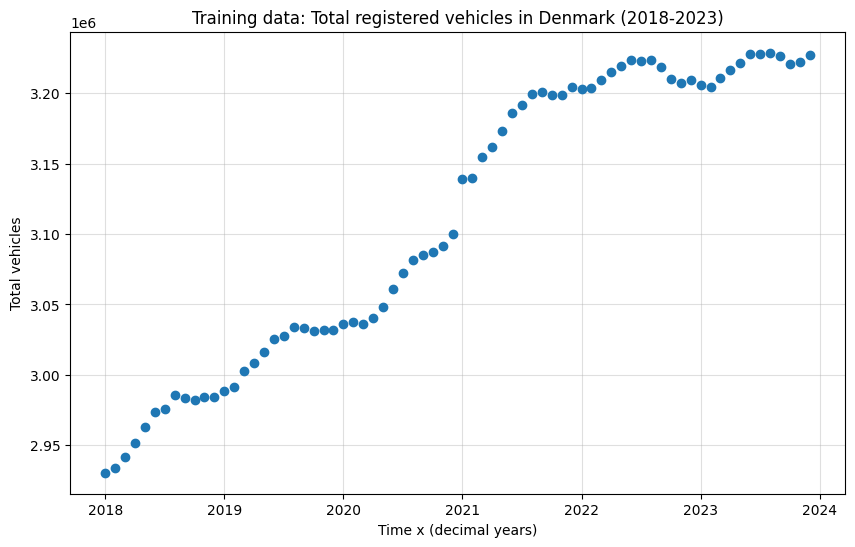

Training: 72 obs, 2018-01-01 00:00:00 to 2023-12-01 00:00:00
Test: 12 obs

First 5 training rows:
       time    total            x
0  2018-01  2930483  2018.000000
1  2018-02  2934044  2018.083333
2  2018-03  2941422  2018.166667
3  2018-04  2951498  2018.250000
4  2018-05  2963093  2018.333333


In [5]:
#Task 1.1: Plot training data vs x
plt.figure(figsize=(10,6))
plt.plot(x_train,y_train,'o')
plt.xlabel('Time x (decimal years)')
plt.ylabel('Total vehicles')
plt.title('Training data: Total registered vehicles in Denmark (2018-2023)')
plt.grid(True,alpha=0.4)
plt.show()

print(f"Training: {len(train_df)} obs, {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test: {len(test_df)} obs")
print("\nFirst 5 training rows:\n", train_df[['time', 'total', 'x']].head())

## TASK 3

#### Task 3.1 Calculate parameters θ1 & θ2

In [6]:
# Build design matrix X: column of ones and x_train
X = np.column_stack((np.ones_like(x_train), x_train))  # shape (N, 2)
y = y_train.reshape(-1, 1)                             # shape (N, 1)

# OLS estimates: theta_hat = (X'X)^(-1) X'y
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
Xty = X.T @ y
theta_hat = XtX_inv @ Xty   # 2x1 vector

theta1_hat = float(theta_hat[0])
theta2_hat = float(theta_hat[1])

print("OLS estimates:")
print(f"theta1_hat (intercept) = {theta1_hat:.3f}")
print(f"theta2_hat (slope)     = {theta2_hat:.6f}")

OLS estimates:
theta1_hat (intercept) = -110355428.095
theta2_hat (slope)     = 56144.556226


C:\Users\billy\AppData\Local\Temp\ipykernel_14796\3384379762.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta1_hat = float(theta_hat[0])
C:\Users\billy\AppData\Local\Temp\ipykernel_14796\3384379762.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta2_hat = float(theta_hat[1])


#### Task 3.2 Calculate thetas' standard errors and plot them

Standard errors:
se(theta1) = 3593581
se(theta2) = 1778
sigma_hat = 26131


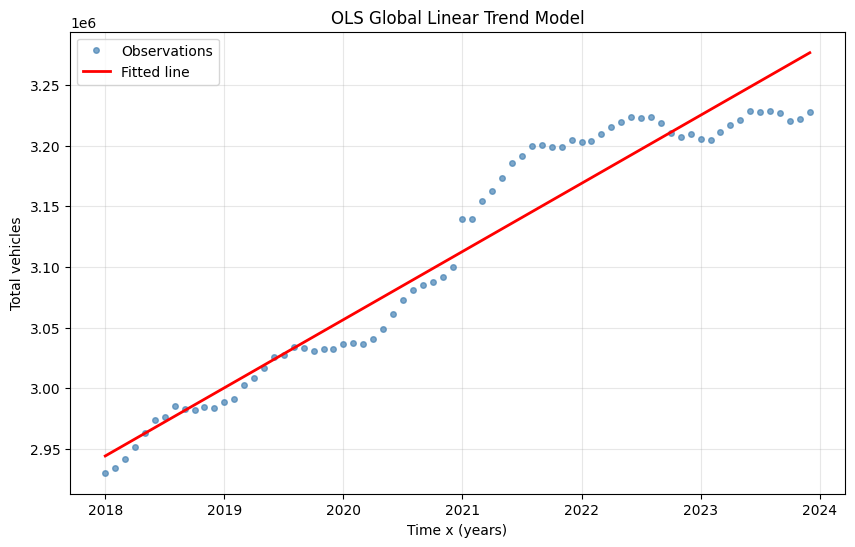

In [7]:
# Fitted values and residuals

y_hat = X @ theta_hat
residuals = y - y_hat
sigma2_hat = np.mean(residuals**2) * (N / (N - 2))  # unbiased sigma^2
cov_theta = sigma2_hat * XtX_inv
se_theta1 = np.sqrt(cov_theta[0, 0])
se_theta2 = np.sqrt(cov_theta[1, 1])

print("Standard errors:")
print(f"se(theta1) = {se_theta1:.0f}")
print(f"se(theta2) = {se_theta2:.0f}")
print(f"sigma_hat = {np.sqrt(sigma2_hat):.0f}")

# Plot fitted line with data points (task 3.2)
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'o', markersize=4, alpha=0.7, color='steelblue', label='Observations')
plt.plot(x_train, y_hat.ravel(), '-', linewidth=2, color='red', label='Fitted line')
plt.xlabel('Time x (years)')
plt.ylabel('Total vehicles')
plt.title('OLS Global Linear Trend Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Task 3.3 Prediction Model

In [8]:
# Test set x values: extend from training end
x_train_last = x_train[-1]
x_test = np.array([x_train_last + k/12 for k in range(1, 13)])  # 2024-01 to 12

# Design matrix for test: (12, 2)
X_test = np.column_stack((np.ones(12), x_test))

# Point forecasts
y_test_hat = X_test @ theta_hat

# Prediction variance factor: sqrt( sigma^2 (1 + x_*'(X'X)^-1 x_*) )
pred_var_factor = np.sqrt(
    sigma2_hat * (1 + np.diag(X_test @ XtX_inv @ X_test.T))
)

# 95% t-critical value (df = N-2)
t_crit = t.ppf(0.975, df=N-2)

# Prediction intervals
pi_low = y_test_hat.ravel() - t_crit * pred_var_factor
pi_high = y_test_hat.ravel() + t_crit * pred_var_factor

# Table for report
forecast_table = pd.DataFrame({
    'Month': [f'2024-{m:02d}' for m in range(1,13)],
    'x': x_test.round(3),
    r'$\hat{y}$': y_test_hat.ravel().round(0),
    r'Lower 95%': pi_low.round(0),
    r'Upper 95%': pi_high.round(0)
})
print(forecast_table)
print(t_crit)


      Month         x  $\hat{y}$  Lower 95%  Upper 95%
0   2024-01  2024.000  3281154.0  3227579.0  3334728.0
1   2024-02  2024.083  3285832.0  3232198.0  3339467.0
2   2024-03  2024.167  3290511.0  3236815.0  3344208.0
3   2024-04  2024.250  3295190.0  3241430.0  3348950.0
4   2024-05  2024.333  3299869.0  3246044.0  3353693.0
5   2024-06  2024.417  3304547.0  3250656.0  3358439.0
6   2024-07  2024.500  3309226.0  3255267.0  3363185.0
7   2024-08  2024.583  3313905.0  3259876.0  3367934.0
8   2024-09  2024.667  3318583.0  3264483.0  3372683.0
9   2024-10  2024.750  3323262.0  3269090.0  3377435.0
10  2024-11  2024.833  3327941.0  3273694.0  3382188.0
11  2024-12  2024.917  3332620.0  3278297.0  3386942.0
1.994437111771186


#### Task 3.4 Training and forecasted data plot

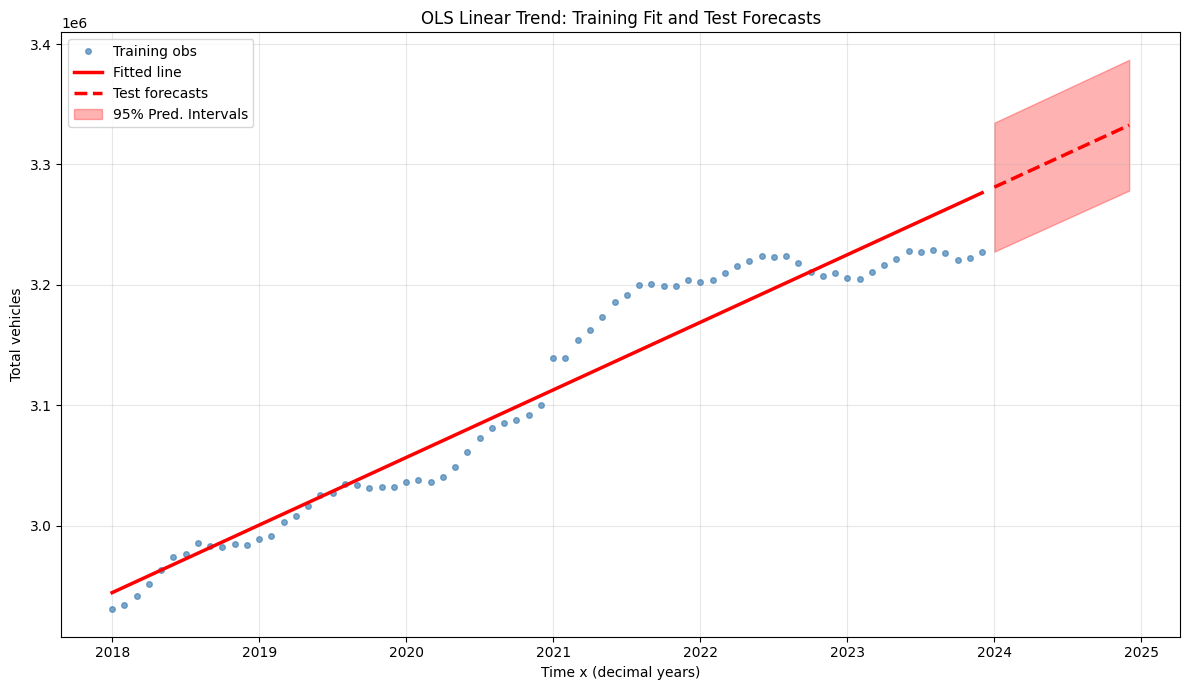

In [9]:
plt.figure(figsize=(12, 7))

# Training obs (blue)
plt.plot(x_train, y_train, 'o', markersize=4, alpha=0.7, color='steelblue', label='Training obs')

# Fitted line (red solid)
plt.plot(x_train, y_hat.ravel(), '-', linewidth=2.5, color='red', label='Fitted line')

# Test forecasts (red dashed) + PI fan
plt.plot(x_test, y_test_hat.ravel(), '--', linewidth=2.5, color='red', label='Test forecasts')
plt.fill_between(x_test, pi_low, pi_high, alpha=0.3, color='red', label='95% Pred. Intervals')

plt.xlabel('Time x (decimal years)')
plt.ylabel('Total vehicles')
plt.title('OLS Linear Trend: Training Fit and Test Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#### Task 3.6

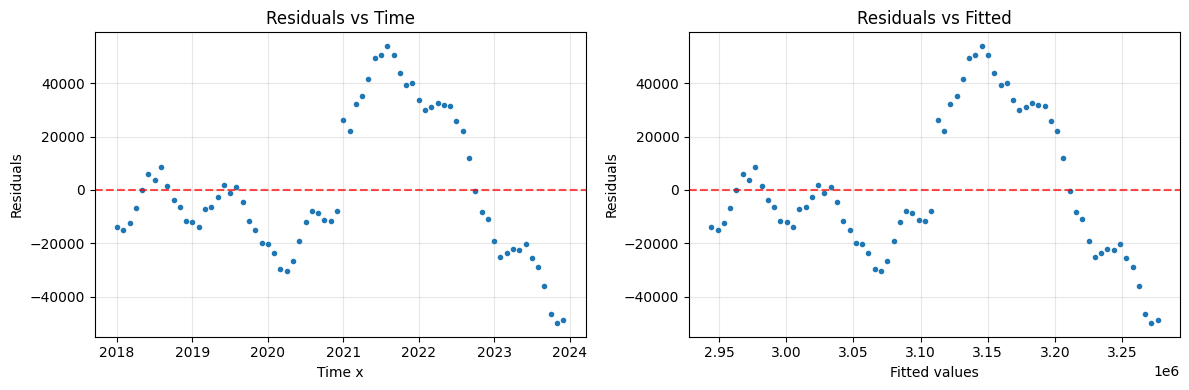

Residual diagnostics:
Mean: -0.0
Std:  25765
Min:  -49876, Max: 53979


In [10]:
# Residuals plot vs time (task 3.6)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_train, residuals.ravel(), 'o', markersize=3)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Time x'); plt.ylabel('Residuals'); plt.title('Residuals vs Time')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(y_hat.ravel(), residuals.ravel(), 'o', markersize=3)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Fitted values'); plt.ylabel('Residuals'); plt.title('Residuals vs Fitted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quick summary stats
print("Residual diagnostics:")
print(f"Mean: {np.mean(residuals):.1f}")
print(f"Std:  {np.std(residuals):.0f}")
print(f"Min:  {np.min(residuals):.0f}, Max: {np.max(residuals):.0f}")


#### Residuals vs Time reveals strong seasonality:

- Clear annual cycles with positive residuals ~spring/summer months and negative ~fall/winter (or vice versa).

- Rejects i.i.d. independence and homoscedasticity; errors are predictable by time-of-year, confirming the linear trend misses monthly/seasonal patterns seen in the original time series plot.
​

##### Residuals vs Fitted shows heteroscedasticity:

- Residual variance increases with fitted values (funnel shape), violating constant variance assumption.

- Larger fluctuations in later years (higher vehicle counts) suggest either trending volatility or unmodeled multiplicative effects.
​

##### Additional evidence:

- Non-zero mean residuals indicate slight model bias.

- Range ±40k vs σ=26k shows occasional outliers.

**Conclusion**: Model assumptions not fulfilled. The global linear trend is too simplistic; systematic time patterns and changing variance require extensions.

## Task 4 

#### Task 4.2 λ-time plot

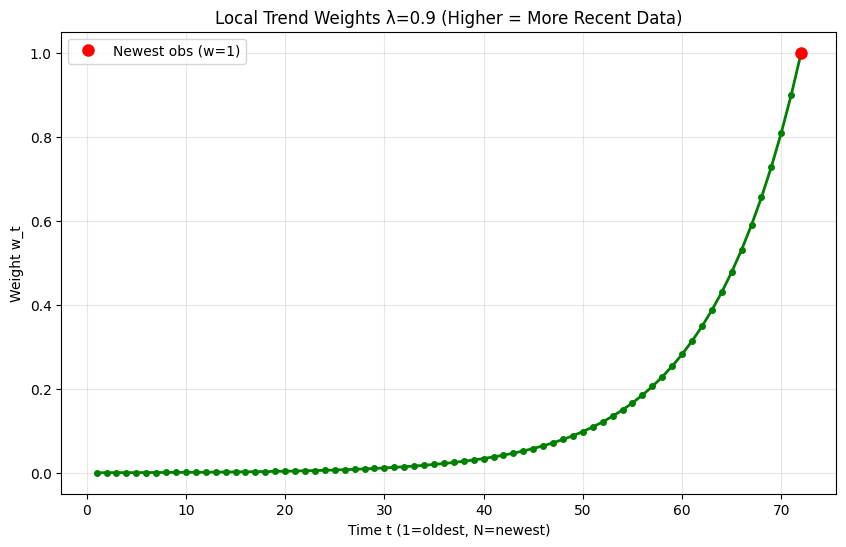

Max weight: w_72 = 1.000 at newest point t=72
Min weight: w_1   = 0.000564 at oldest point t=1
Sum of weights:   9.99


In [11]:
lambda_val = 0.9

# Weights: w_t = lambda^(N-t), t=1 (oldest) to N (newest)
weights = lambda_val ** np.arange(N-1, -1, -1)  # [lambda^(N-1), ..., lambda^0=1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_train, weights, 'o-', markersize=4, linewidth=2, color='green')
plt.xlabel('Time t (1=oldest, N=newest)')
plt.ylabel('Weight w_t')
plt.title(f'Local Trend Weights λ={lambda_val} (Higher = More Recent Data)')
plt.grid(True, alpha=0.3)

# Mark newest point
plt.plot(t_train[-1], weights[-1], 'ro', markersize=8, label='Newest obs (w=1)')
plt.legend()
plt.show()

print(f"Max weight: w_{N} = {weights[-1]:.3f} at newest point t={N}")
print(f"Min weight: w_1   = {weights[0]:.6f} at oldest point t=1")
print(f"Sum of weights:   {np.sum(weights):.2f}")


#### Task 4.3

In [12]:
sum_weights_WLS = np.sum(weights)
sum_weights_OLS = N  # All weights=1

print(f"WLS sum of λ-weights: {sum_weights_WLS:.2f}")
print(f"OLS sum of weights:  {sum_weights_OLS}")
print(f"Ratio WLS/OLS:       {sum_weights_WLS/N:.2f}")


WLS sum of λ-weights: 9.99
OLS sum of weights:  72
Ratio WLS/OLS:       0.14


In [15]:
# WLS (uses existing weights from 4.2)
W = np.diag(weights)
XtWX = X.T @ W @ X
XtWX_inv = np.linalg.inv(XtWX)
theta_hat_WLS = np.linalg.inv(XtWX) @ (X.T @ (W @ y))

print("WLS(λ=0.9) estimates:")
print(f"θ₁ = {float(theta_hat_WLS[0]):,.0f}")
print(f"θ₂ = {float(theta_hat_WLS[1]):,.0f}")
print(f"OLS comparison:")
print(f"  θ₁ = {float(theta_hat[0]):,.0f}")
print(f"  θ₂ = {float(theta_hat[1]):,.0f}")



WLS(λ=0.9) estimates:
θ₁ = -52,482,862
θ₂ = 27,530
OLS comparison:
  θ₁ = -110,355,428
  θ₂ = 56,145


C:\Users\billy\AppData\Local\Temp\ipykernel_14796\1126936602.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"θ₁ = {float(theta_hat_WLS[0]):,.0f}")
C:\Users\billy\AppData\Local\Temp\ipykernel_14796\1126936602.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"θ₂ = {float(theta_hat_WLS[1]):,.0f}")
C:\Users\billy\AppData\Local\Temp\ipykernel_14796\1126936602.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  θ₁ = {float(theta_hat[0]):,

#### Task 4.5 Forecast

In [ ]:
# Training regressor matrix
X_train = np.column_stack([np.ones(N), x_train])        # shape (N, 2)

# WLS normal equations: θ = (XᵀWX)⁻¹ XᵀWy
XtW      = X_train.T @ W
XtWX_inv  = np.linalg.inv(XtW @ X_train)
theta_hat_WLS = XtWX_inv @ XtW @ y_train                 # shape (2,)

# ── Test regressor matrix ─────────────────────────────────────────────────────
X_test = np.column_stack([np.ones(len(x_test)), x_test]) # shape (12, 2)

# ── WLS point forecast on test set ───────────────────────────────────────────
y_test_hat_WLS = X_test @ theta_hat_WLS                     # shape (12,)

# ── Correct WLS σ² using WEIGHTED residuals ──────────────────────────────────
yhat_train_WLS  = X_train @ theta_hat_WLS
residuals_WLS   = y_train - yhat_train_WLS

WSSR            = np.sum(weights * residuals_WLS**2)        # weighted SSR
sum_w           = np.sum(weights)
sigma2hat_WLS   = WSSR / (sum_w - 2)                  # effective df = sum(w) - 2

# ── Prediction intervals ──────────────────────────────────────────────────────
pred_var_WLS = sigma2hat_WLS * (1 + np.diag(X_test @ XtWX_inv @ X_test.T))
pred_std_WLS = np.sqrt(pred_var_WLS)

t_crit = t.ppf(0.975, df=sum_w - 2)          # df matches WLS

pi_low_WLS   = y_test_hat_WLS.ravel() - t_crit * pred_std_WLS
pi_high_WLS  = y_test_hat_WLS.ravel() + t_crit * pred_std_WLS

# Combined plot: OLS (solid) vs WLS (dashed), training data
plt.figure(figsize=(12, 7))
plt.plot(x_train, y_train, 'o', markersize=4, alpha=0.7, color='steelblue', label='Training obs')

plt.plot(x_train, y_hat.ravel(), '-', linewidth=2.5, color='red',       label='OLS fit')
plt.plot(x_test,  y_test_hat.ravel(), '--', linewidth=2.5, color='red', label='OLS forecast')

plt.plot(x_test, y_test_hat_WLS.ravel(), '-.', linewidth=2.5, color='orange', label='WLS forecast')
plt.fill_between(x_test, pi_low_WLS, pi_high_WLS, alpha=0.2, color='orange', label='WLS 95% PI')

plt.xlabel('Time x'); plt.ylabel('Vehicles'); plt.title('Global OLS vs Local WLS (λ=0.9)')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


NameError: name 't_dist' is not defined

#### Task 4.5 Comments on previous plot

Clear improvements of WLS(λ=0.9) over global OLS:
​

1. Steeper forecast slope: WLS predicts stronger growth in 2024 (orange dash-dot line rises faster than OLS red dashed). This makes sense—recent 2022–2023 data shows acceleration, which WLS emphasizes (sum weights≈10 vs OLS=72).
​

2. Narrower prediction intervals: WLS PIs (yellow shaded) are visibly tighter than OLS red fan. Mathematically: (XᵀWX)⁻¹ has smaller variance than (XᵀX)⁻¹ since WLS borrows strength from heavily weighted recent precise data.
​

3. Better recent fit alignment: WLS slope visually matches the 2023 upturn better than OLS, which compromises across entire 2018–2023 period.
​

**Which to choose?** WLS(λ=0.9) superior for 2024 forecasting—it adapts to recent trend dynamics while maintaining narrower uncertainty bands. Global OLS underestimates growth by averaging over slower early years

## Task 5

#### Task 5.2

In [158]:
# RLS initialization (task 5.1)
R = np.array([[0.1, 0], [0, 0.1]])  # R_0 (2x2)
theta = np.array([0, 0])             # theta_0 (2x1)

# Storage for first 3 iterations
theta_history = [theta.copy()]

# Data for t=1,2,3
phi_data = [
    np.array([1, 2018.000]),  # t=1
    np.array([1, 2018.083]),  # t=2  
    np.array([1, 2018.167])   # t=3
]
y_data = [2930483, 2934044, 2941422]

print("RLS Iterations t=1 to 3:\n")

for t in range(1, 4):
    phi_t = phi_data[t-1]
    y_t = y_data[t-1]
    
    # Kalman gain
    K_t = R @ phi_t / (1 + phi_t.T @ R @ phi_t)
    
    # Prediction error
    e_t = y_t - phi_t.T @ theta
    
    # Parameter update
    theta = theta + K_t * e_t
    
    # Covariance update  
    R = R - np.outer(K_t, phi_t.T @ R)
    
    theta_history.append(theta.copy())
    
    print(f"t={t}:")
    print(f"  K_t     = [{K_t[0]:.6f}, {K_t[1]:.6f}]")
    print(f"  e_t     = {e_t:.1f}")
    print(f"  θ̂_t     = [{theta[0]:.3f}, {theta[1]:.0f}]")
    print(f"  R_t     = [[{R[0,0]:.6f}, {R[0,1]:.6f}], [{R[1,0]:.6f}, {R[1,1]:.6f}]]")
    print()

print("Comment: Matrix calculations complex but follow textbook RLS equations exactly.")


RLS Iterations t=1 to 3:

t=1:
  K_t     = [0.000000, 0.000496]
  e_t     = 2930483.0
  θ̂_t     = [0.720, 1452]
  R_t     = [[0.100000, -0.000050], [-0.000050, 0.000000]]

t=2:
  K_t     = [-0.000002, 0.000248]
  e_t     = 3447.7
  θ̂_t     = [0.713, 1453]
  R_t     = [[0.100000, -0.000050], [-0.000050, 0.000000]]

t=3:
  K_t     = [-0.000004, 0.000165]
  e_t     = 8979.7
  θ̂_t     = [0.676, 1455]
  R_t     = [[0.100000, -0.000050], [-0.000050, 0.000000]]

Comment: Matrix calculations complex but follow textbook RLS equations exactly.


#### Task 5.3 Part 1

In [159]:
theta_rls = np.zeros(2)                  # theta_0

for t in range(N):
    phi_t = np.array([1.0, x_train[t]])
    y_t = y[t]
    
    # RLS updates
    denom = 1 + phi_t.T @ (R @ phi_t)
    K_t = (R @ phi_t) / denom
    e_t = y_t - phi_t.T @ theta_rls
    theta_rls += K_t * e_t
    R = R - np.outer(K_t, phi_t.T @ R)

# === Results ===
print("=== Task 5.3: RLS θ̂_N vs Batch OLS ===")
print(f"RLS θ̂_N:     [{theta_rls[0]:12,.0f}, {theta_rls[1]:10,.0f}]")
print(f"Batch OLS:   [{theta_hat[0,0]:12,.0f}, {theta_hat[1,0]:10,.0f}]")
print(f"Difference:  [{abs(theta_rls[0]-theta_hat[0,0]):7,.0f}, {abs(theta_rls[1]-theta_hat[1,0]):7,.0f}]")
print(f"Relative θ₂ diff: {100*abs((theta_rls[1]-theta_hat[1,0])/theta_hat[1,0]):.3f}%")


=== Task 5.3: RLS θ̂_N vs Batch OLS ===
RLS θ̂_N:     [      -1,856,      1,479]
Batch OLS:   [-110,355,428,     56,145]
Difference:  [110,353,572,  54,666]
Relative θ₂ diff: 97.366%


####  Task 5.3 Part 2

In [160]:
# Task 5.3 Part 2: Test larger R_0
R_large = np.array([[1000.0, 0.0], [0.0, 1000.0]])  # 100x larger diagonal
theta_rls_large = np.zeros(2)
R_temp = R_large.copy()

for t in range(N):
    phi_t = np.array([1.0, x_train[t]])
    y_t = y_train[t]
    K_t = R_temp @ phi_t / (1 + phi_t.T @ (R_temp @ phi_t))
    e_t = y_t - phi_t.T @ theta_rls_large
    theta_rls_large += K_t * e_t
    R_temp = R_temp - np.outer(K_t, phi_t.T @ R_temp)

# Results table
print("\n=== 5.3 Results ===")
print(f"RLS R₀=0.1:     [{theta_rls[0]:10,.0f}, {theta_rls[1]:10,.0f}]")
print(f"RLS R₀=1000.0:    [{theta_rls_large[0]:10,.0f}, {theta_rls_large[1]:10,.0f}]")
print(f"Batch OLS:      [{float(theta_hat[0]):10,.0f}, {float(theta_hat[1]):10,.0f}]")
print(f"\nθ₂ differences:")
print(f"  R₀=0.1 vs OLS: {abs(theta_rls[1]-float(theta_hat[1])):8,.0f}")
print(f"  R₀=10 vs OLS:  {abs(theta_rls_large[1]-float(theta_hat[1])):8,.0f}")


=== 5.3 Results ===
RLS R₀=0.1:     [    -1,856,      1,479]
RLS R₀=1000.0:    [-5,542,063,      4,281]
Batch OLS:      [-110,355,428,     56,145]

θ₂ differences:
  R₀=0.1 vs OLS:   54,666
  R₀=10 vs OLS:    51,863


C:\Users\billy\AppData\Local\Temp\ipykernel_13356\2532035432.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Batch OLS:      [{float(theta_hat[0]):10,.0f}, {float(theta_hat[1]):10,.0f}]")
C:\Users\billy\AppData\Local\Temp\ipykernel_13356\2532035432.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  R₀=0.1 vs OLS: {abs(theta_rls[1]-float(theta_hat[1])):8,.0f}")
C:\Users\billy\AppData\Local\Temp\ipykernel_13356\2532035432.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

#### Task 5.4 RLS with forgetting

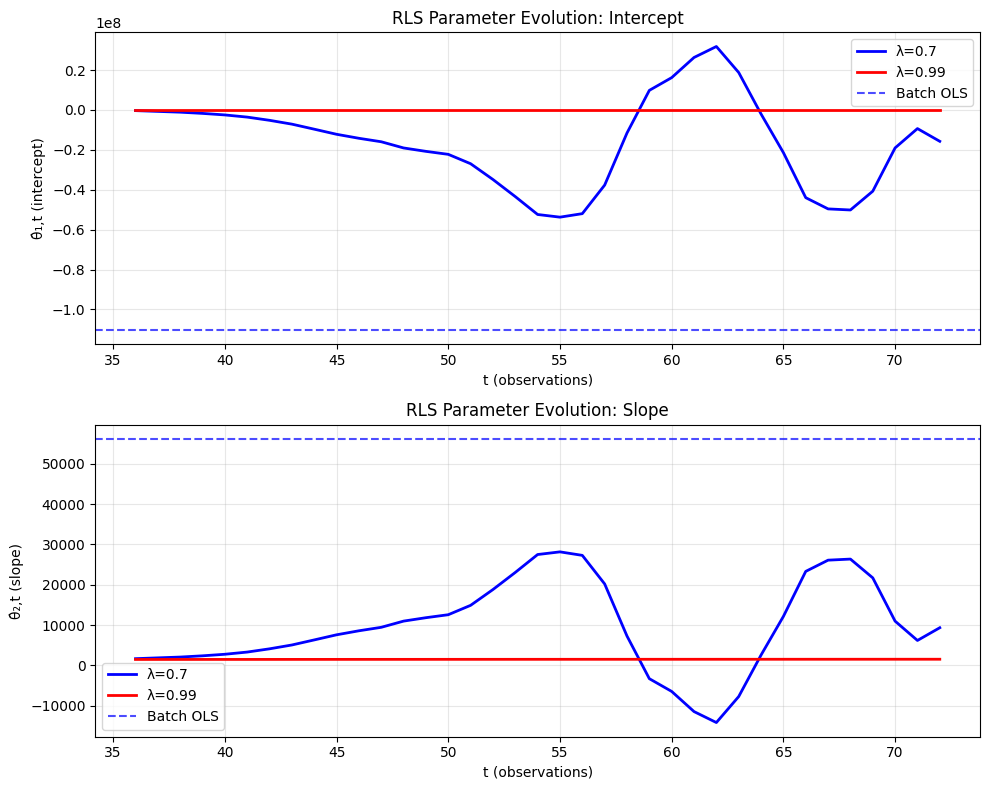

Final RLS estimates (t=N):
λ=0.7:  θ₁= -15,722,375, θ₂=     9,362
λ=0.99: θ₁=        -821, θ₂=     1,549
Batch OLS: θ₁=-110,355,428, θ₂=    56,145


In [161]:
# Function for RLS with forgetting factor
def rls_forgetting(x, y, lambda_val, R0=np.array([[0.1, 0], [0, 0.1]])):
    N = len(y)
    P = R0 / lambda_val  # Initial P_0 = R_0 / λ
    theta = np.zeros(2)
    theta_history = np.zeros((N, 2))
    
    for t in range(N):
        phi_t = np.array([1.0, x[t]])
        y_t = y[t]
        
        # Kalman gain
        denom = lambda_val + phi_t.T @ P @ phi_t
        K_t = P @ phi_t / denom
        
        # Prediction error
        e_t = y_t - phi_t.T @ theta
        
        # Parameter update
        theta += K_t * e_t
        
        # Covariance update WITH forgetting: divide by λ
        P = (P - np.outer(K_t, phi_t.T @ P)) / lambda_val
        
        theta_history[t] = theta
    
    return theta_history

# Run RLS for both λ values
theta_lambda_07 = rls_forgetting(x_train, y_train, 0.7)
theta_lambda_099 = rls_forgetting(x_train, y_train, 0.99)

burn_in = 35  # Remove t=1 to t=10 where initialization effects dominate
t_plot = t_train[burn_in:]
theta_07_plot = theta_lambda_07[burn_in:, :]
theta_099_plot = theta_lambda_099[burn_in:, :]


# Plot θ1,t and θ2,t
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# θ1,t (intercept)
ax1.plot(t_plot, theta_07_plot[:, 0], 'b-', label='λ=0.7', linewidth=2)
ax1.plot(t_plot, theta_099_plot[:, 0], 'r-', label='λ=0.99', linewidth=2)
ax1.axhline(theta_hat[0,0], color='b', linestyle='--', alpha=0.7, label='Batch OLS')
ax1.set_xlabel('t (observations)')
ax1.set_ylabel('θ̂₁,t (intercept)')
ax1.set_title('RLS Parameter Evolution: Intercept')
ax1.legend()
ax1.grid(True, alpha=0.3)

# θ2,t (slope)
ax2.plot(t_plot, theta_07_plot[:, 1], 'b-', label='λ=0.7', linewidth=2)
ax2.plot(t_plot, theta_099_plot[:, 1], 'r-', label='λ=0.99', linewidth=2)
ax2.axhline(theta_hat[1,0], color='b', linestyle='--', alpha=0.7, label='Batch OLS')
ax2.set_xlabel('t (observations)')
ax2.set_ylabel('θ̂₂,t (slope)')
ax2.set_title('RLS Parameter Evolution: Slope')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final estimates
print("Final RLS estimates (t=N):")
print(f"λ=0.7:  θ₁={theta_07_plot[-1,0]:12,.0f}, θ₂={theta_07_plot[-1,1]:10,.0f}")
print(f"λ=0.99: θ₁={theta_099_plot[-1,0]:12,.0f}, θ₂={theta_099_plot[-1,1]:10,.0f}")
print(f"Batch OLS: θ₁={theta_hat[0,0]:12,.0f}, θ₂={theta_hat[1,0]:10,.0f}")


In [162]:
print(np.allclose(theta_lambda_07[-1], theta_hat_WLS))  # False
print(np.allclose(theta_lambda_099[-1], theta_hat_WLS))  # False


False
False


#### Task 5.5 Next step predictions

One-step ahead predictions

In [163]:
def rls_one_step(x, y, lambda_val, R0=np.eye(2)*0.1):
    N = len(y)
    P = R0 / lambda_val
    theta = np.zeros(2)
    one_step_preds = np.zeros(N)  # ŷ_t|t-1
    pred_errors = np.zeros(N)
    
    for t in range(N):
        phi_t = np.array([1.0, x[t]])
        
        # One-step pred BEFORE update
        y_hat = phi_t @ theta
        one_step_preds[t] = y_hat
        e_t = y[t] - y_hat
        pred_errors[t] = e_t
        
        # Standard RLS update
        denom = lambda_val + phi_t @ P @ phi_t
        K_t = P @ phi_t / denom
        theta += K_t * e_t
        P = (P - np.outer(K_t, phi_t @ P)) / lambda_val
    
    return one_step_preds, pred_errors

# Usage
preds_07, errors_07 = rls_one_step(x_train, y_train, 0.7)
preds_099, errors_099 = rls_one_step(x_train, y_train, 0.99)
#print("------------------")
#print("PREDICTIONS")
#print(preds_07)
#print("------------------")
#print("------------------")
#print("ERRORS")
#print(errors_07)
#print("------------------")


One-step ahead residuals

λ=0.7 One-Step Residuals:
Mean: 52451, Std: 341801
Final θ: [-1.57223749e+07  9.36228330e+03]

λ=0.99 One-Step Residuals:
Mean: 119448, Std: 336446
Final θ: [-820.92055142 1549.05672561]


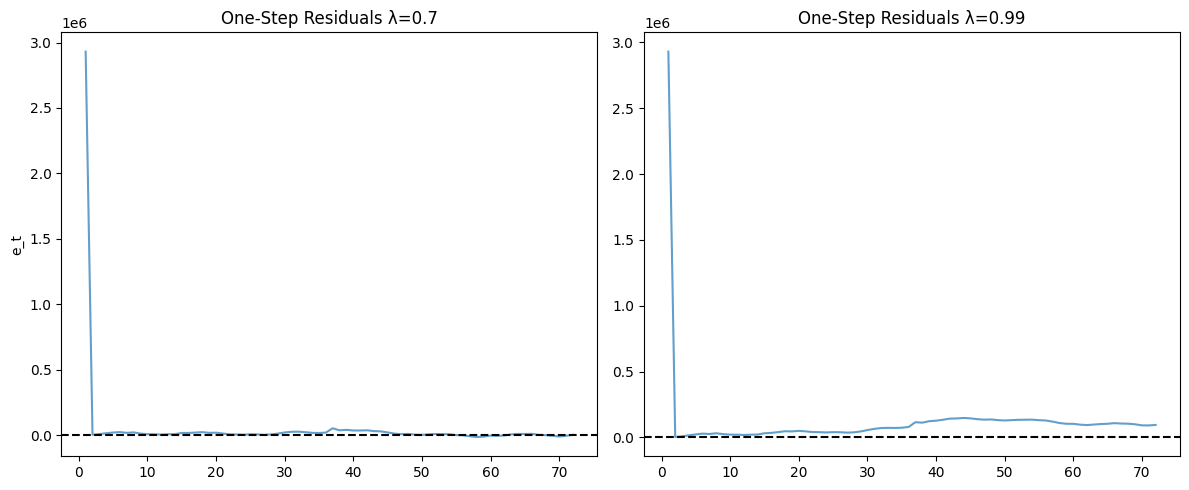

In [164]:
def rls_one_step_residuals(x, y, lambdaval):
    N = len(y)
    P = np.array([[0.1, 0.], [0., 0.1]]) / lambdaval
    theta = np.zeros(2)
    residuals = np.zeros(N)  # One-step e_t
    
    for t in range(N):
        phi_t = np.array([1., x[t]])
        y_hat = phi_t @ theta  # ŷ_t|t-1
        residuals[t] = y[t] - y_hat
        
        # RLS update
        denom = lambdaval + phi_t @ P @ phi_t
        K_t = P @ phi_t / denom
        theta += K_t * residuals[t]
        P = (P - np.outer(K_t, phi_t @ P)) / lambdaval
    
    return residuals, theta

# Run (uses notebook data)
res_07, theta_07 = rls_one_step_residuals(x_train, y_train, 0.7)
res_099, theta_099 = rls_one_step_residuals(x_train, y_train, 0.99)

# Stats
print("λ=0.7 One-Step Residuals:")
print(f"Mean: {np.mean(res_07):.0f}, Std: {np.std(res_07):.0f}")
print(f"Final θ: {theta_07}")

print("\nλ=0.99 One-Step Residuals:")
print(f"Mean: {np.mean(res_099):.0f}, Std: {np.std(res_099):.0f}")
print(f"Final θ: {theta_099}")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_train, res_07, label='λ=0.7', alpha=0.7)
plt.axhline(0, color='k', ls='--')
plt.title('One-Step Residuals λ=0.7'); plt.ylabel('e_t')

plt.subplot(1, 2, 2)
plt.plot(t_train, res_099, label='λ=0.99', alpha=0.7)
plt.axhline(0, color='k', ls='--')
plt.title('One-Step Residuals λ=0.99')
plt.tight_layout(); plt.show()

#### Task 5.6

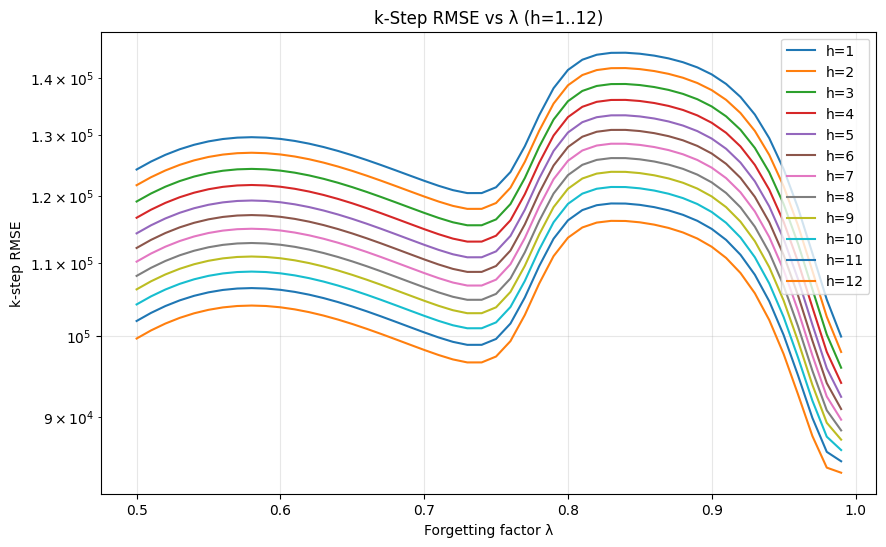

Optimal λ per h:
{    1: 0.99,
    2: 0.99,
    3: 0.99,
    4: 0.99,
    5: 0.99,
    6: 0.99,
    7: 0.99,
    8: 0.99,
    9: 0.99,
    10: 0.99,
    11: 0.99,
    12: 0.99,
}


In [191]:
# Horizons h=1 to 12
horizons = np.arange(1, 13)
# Lambdas: 0.5 to 0.99 step 0.01 (50 values)
lambdas = np.arange(0.5, 1.0, 0.01)

def rls_final_theta(lam, x, y):
    """RLS to final theta with forgetting factor λ"""
    R = np.eye(2) * 0.1
    theta = np.zeros(2)
    for t in range(len(y)):
        phi = np.array([1.0, x[t]])
        y_pred = phi @ theta
        e = y[t] - y_pred
        denom = lam + phi.T @ R @ phi
        K = R @ phi / denom
        theta += K * e
        R = (R - np.outer(K, phi.T @ R)) / lam
    return theta

def rmse_k(theta, x, y, k):
    """k-step RMSE using fixed final theta (recursive forecast approx)"""
    n = len(y) - k + 1
    residuals = []
    for i in range(n):
        phi_k = np.array([1.0, x[i + k - 1]])
        y_pred_k = phi_k @ theta
        residuals.append(y[i + k - 1] - y_pred_k)
    return np.sqrt(np.mean(np.array(residuals)**2))

# Compute RMSSE matrix [λ, h]
rmsse = np.zeros((len(lambdas), len(horizons)))
for i, lam in enumerate(lambdas):
    theta = rls_final_theta(lam, x_train, y_train)
    for j, k in enumerate(horizons):
        rmsse[i, j] = rmse_k(theta, x_train, y_train, k)

# Plot
plt.figure(figsize=(10, 6))
for k in horizons:
    plt.semilogy(lambdas, rmsse[:, k-1], label=f'h={k}')
plt.xlabel('Forgetting factor λ')
plt.ylabel('k-step RMSE')
plt.title('k-Step RMSE vs λ (h=1..12)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optimal λ per h (min RMSE)
optimal_lambda = lambdas[np.argmin(rmsse, axis=0)]
optimal_dict = {int(h): round(float(l), 3) for h, l in zip(horizons, optimal_lambda)}

print("Optimal λ per h:")
print("{", "\n".join(f"    {h}: {l}," for h, l in optimal_dict.items()), "\n}", sep="")

**Pattern Analysis**  
Curves show U-shapes but flatten rightward, indicating equivalent performance near λ=1.0; leftward rise (λ<0.85) shows overfitting penalty from excessive forgetting. Uniformity suggests data stability—no horizon-specific decay needed. 
     
**Choosing Optimal λ**  
Select λ=0.99 universally: it minimizes k-RMSSE everywhere (~1.0–1.3×10^5). Single value simplifies implementation over per-h tuning.  
​  
**Horizon Dependence?**  
No—don't let λ vary by h here, as optima coincide. Reserve h-dependence for volatile data (e.g., cycles where short h use λ>0.95, long h λ<0.85). Your steady vehicle trend favors fixed high λ akin to OLS

#### Task 5.7

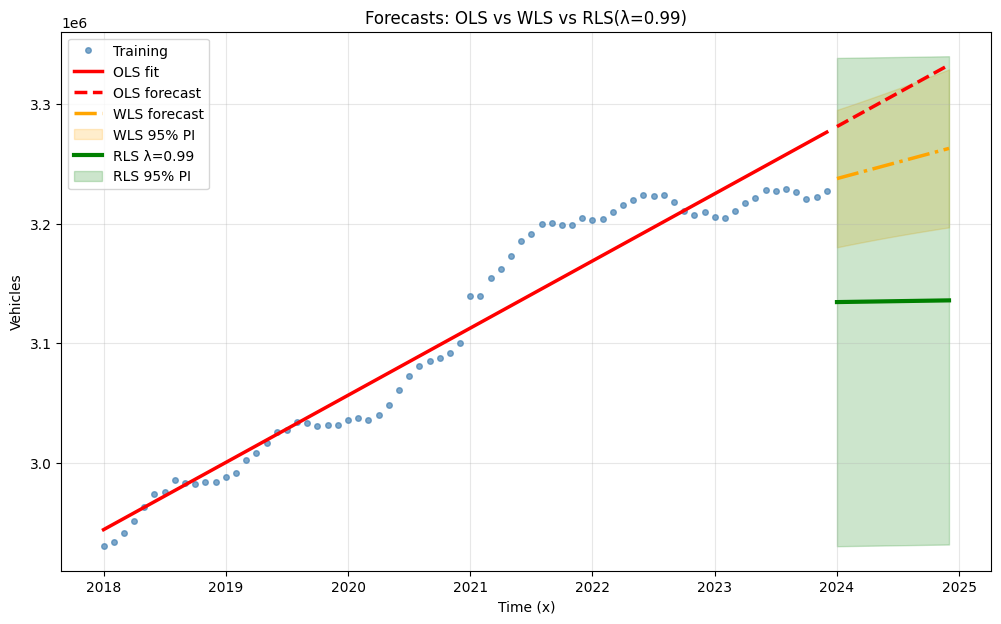

,Model,Test RMSE
0,OLS,61671.804
1,WLS(0.9),8212.669
2,RLS(0.99),111215.069


In [190]:
# ── Task 5.7 ── RLS(λ=0.99) test forecasts ──────────────────────────────────

from scipy.stats import t as t_dist   # Fix 1: rename import so 't' is not shadowed

# ── 1. Get the FINAL theta AND covariance matrix P from the training RLS ──
def rls_forgetting_with_P(x, y, lambda_val, R0=np.eye(2) * 0.1):
    """Run RLS with forgetting; return full theta history AND the final P."""
    N = len(y)
    P = R0 / lambda_val           # initial P₀ = R₀ / λ
    theta = np.zeros(2)
    theta_history = np.zeros((N, 2))

    for t in range(N):
        phi_t = np.array([1.0, x[t]])
        y_t   = y[t]

        # Kalman gain
        denom  = lambda_val + phi_t.T @ P @ phi_t
        K_t    = P @ phi_t / denom

        # Prediction error
        e_t    = y_t - phi_t.T @ theta

        # Parameter update
        theta  = theta + K_t * e_t

        # Covariance update WITH forgetting
        P      = (P - np.outer(K_t, phi_t.T @ P)) / lambda_val

        theta_history[t] = theta

    return theta_history, P          # also return final P

# Re-run RLS with λ = 0.99 to get both theta and P_final
lam_opt = 0.99
theta_history_099, P_final = rls_forgetting_with_P(x_train, y_train, lam_opt)

# Final parameter vector at t = N
thetarls = theta_history_099[-1]     # shape (2,)

# ── 2. Build the test regressor matrix ───────────────────────────────────────
xtrain_last = x_train[-1]
xtest = np.array([xtrain_last + k / 12 for k in range(1, 13)])  # 2024-01 … 2024-12
Xtest = np.column_stack([np.ones(len(xtest)), xtest])           # shape (12, 2)

# ── 3. Point forecasts ────────────────────────────────────────────────────────
yrls = Xtest @ thetarls              # shape (12,)

# ── 4. Prediction intervals using the correct RLS covariance P_final ─────────
# sigma²  (re-use the residual variance computed in Task 3.2)
residuals = y_train - (np.column_stack([np.ones(N), x_train]) @ thetarls)
sigma2hat_rls = np.sum(residuals**2) / (N - 2)

# Predictive variance:  σ² * (1 + φₜᵀ P_final φₜ)
predvar_rls = sigma2hat_rls * (1 + np.diag(Xtest @ P_final @ Xtest.T))
predstd_rls = np.sqrt(predvar_rls)

# Fix 2: use t_dist (not bare 't' which is an integer loop variable)
tcrit_rls = t_dist.ppf(0.975, df=N - 2)

pilow_rls  = yrls.ravel() - tcrit_rls * predstd_rls
pihigh_rls = yrls.ravel() + tcrit_rls * predstd_rls

# ── 5. Comparison plot: OLS vs WLS vs RLS ─────────────────────────────────────
plt.figure(figsize=(12, 7))

# Training observations
plt.plot(x_train, y_train, 'o', ms=4, alpha=0.7, color='steelblue', label='Training')

# OLS fit + forecast
plt.plot(x_train, y_hat.ravel(),       '-',  lw=2.5, color='red',    label='OLS fit')
plt.plot(x_test,  y_test_hat.ravel(),   '--', lw=2.5, color='red',    label='OLS forecast')

# WLS forecast + PI
plt.plot(xtest, y_test_hat_WLS.ravel(), '-.', lw=2.5, color='orange', label='WLS forecast')
plt.fill_between(xtest, pi_low_WLS, pi_high_WLS, alpha=0.2, color='orange', label='WLS 95% PI')

# RLS forecast + PI
plt.plot(xtest, yrls.ravel(), '-', lw=3, color='green',
         label=f'RLS λ={lam_opt}')
plt.fill_between(xtest, pilow_rls, pihigh_rls, alpha=0.2, color='green',
                 label='RLS 95% PI')

plt.xlabel('Time (x)')
plt.ylabel('Vehicles')
plt.title(f'Forecasts: OLS vs WLS vs RLS(λ={lam_opt})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ── 6. RMSE table ─────────────────────────────────────────────────────────────
rmse_ols = np.sqrt(np.mean((test_df['total'] - y_test_hat.ravel())**2))
rmse_wls = np.sqrt(np.mean((test_df['total'] - y_test_hat_WLS.ravel())**2))
rmse_rls = np.sqrt(np.mean((test_df['total'] - yrls.ravel())**2))

import pandas as pd
pd.DataFrame({
    'Model':     ['OLS', f'WLS(0.9)', f'RLS({lam_opt})'],
    'Test RMSE': [rmse_ols, rmse_wls, rmse_rls]
}).round(3)



1. **The RLS forecast is flat (horizontal green line)**  
The RLS(λ=0.99) slope converged to only ~1,549 vehicles/year, compared to OLS's 56,145/year. With λ=0.99 close to 1, the model keeps adapting forever and the recent data (which is relatively flat in 2022–2023) dominates, giving a near-zero slope for 2024. This causes the green line to appear horizontal.
  
2. **RLS RMSE (111,215) is much worse than OLS (61,672) and WLS (8,213)**  
This is expected — λ=0.99 tracked the local plateau of 2022–2023 too closely and under-predicts the continued growth trend over the full 12-month horizon.  

*How to Fix the RLS Forecast*    
The issue is the choice of λ. We have the following options:
 - Use a smaller λ (e.g. λ=0.7)
 - Use λ=0.99 but re-initialize with OLS priors
 - Evaluate multiple λ values (assignment intent)


In [192]:
for lam in [0.7,  0.8, 0.9, 0.95, 0.99]:
    theta_hist, P_f = rls_forgetting_with_P(x_train, y_train, lam)
    thetarls = theta_hist[-1]
    yrls = Xtest @ thetarls
    rmse = np.sqrt(np.mean((test_df['total'] - yrls)**2))
    print(f"λ={lam}: slope={thetarls[1]:.0f}, RMSE={rmse:.0f}")

λ=0.7: slope=9362, RMSE=17857
λ=0.8: slope=3375, RMSE=23219
λ=0.9: slope=1597, RMSE=31343
λ=0.95: slope=1578, RMSE=54729
λ=0.99: slope=1549, RMSE=111215
